# Super Resolution using CNN

According to the paper, 'Image Super-Resolution Using Deep Convolutional Networks' it is possible to represent the entire process of Super-Resolution as a Deep Convolution Neural Network. This is a naive implementation of the same.

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import tensorflow.keras
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
from tensorflow.keras import models,layers,datasets,optimizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import cv2

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## Loading the Dataset

The model is trained using `Linnaeus 5` Dataset. The training set consists of 6000 images and the test set has 2000 images. All the images have resolution 256x256.


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
def load_data():
    train_1 = load_images_from_folder('d1/train/berry')
    train_2 = load_images_from_folder('d1/train/bird')
    train_3 = load_images_from_folder('d1/train/dog')
    train_4 = load_images_from_folder('d1/train/flower')
    train_5 = load_images_from_folder('d1/train/other')
    
    
    test_1 = load_images_from_folder('d1/test/berry')
    test_2 = load_images_from_folder('d1/test/bird')
    test_3 = load_images_from_folder('d1/test/dog')
    test_4 = load_images_from_folder('d1/test/flower')
    test_5 = load_images_from_folder('d1/test/other')
    
    train = train_1 + train_2 + train_3 + train_4 + train_5
    test = test_1 + test_2 + test_3 + test_4 + test_5
    
    return train, test

In [5]:
train, test = load_data()

In [7]:
print(len(train))
print(len(test))

6000
2000


## Data Preprocessing

Since the model takes `res_low`x`res_low`(64x64) image as input and outputs a `res_high`x`res_high`(128x128) image, the original 256x256 images were resized to the required dimensions.

In [6]:
res_high = 128
res_low = 64

In [8]:
def reduce_resolution(data, res):
    low_res = []
    for img in data:
        img_low_res = cv2.resize(img,(res,res))
        low_res.append(img_low_res)
        
    return low_res

In [9]:
train = reduce_resolution(train,res_high)
test = reduce_resolution(test,res_high)

train_low = reduce_resolution(train,res_low)
test_low = reduce_resolution(test,res_low)

In [10]:
train = np.reshape(train,(len(train),res_high,res_high,3))
test = np.reshape(test,(len(test),res_high,res_high,3))

train_low = np.reshape(train_low,(len(train_low),res_low,res_low,3))
test_low = np.reshape(test_low,(len(test_low),res_low,res_low,3))

In [11]:
print(train.shape)
print(test.shape)

print(train_low.shape)
print(test_low.shape)

(6000, 128, 128, 3)
(2000, 128, 128, 3)
(6000, 64, 64, 3)
(2000, 64, 64, 3)


In [12]:
data_train = train_low
labels_train = train

data_test = test_low
labels_test = test

## Model Architecture

The model architecture used here is similar to the one given in 'Reconstructing Obfuscated Human Faces' project report by Jacob Conrad Trinidad.


After `BatchNorm` the input is sent through 4 `Conv` layers. Then it is sent through 3 block of `ResNet`, where each block has 2 `Conv` layers. Then finally we have 4 `Conv Transpose` layers. All the Conv and Conv Transpose layers are followed by `Relu` and `BatchNorm` except the last one. The last layer uses `tanh` activation which is followed by a `Rescaling` to 255.

In [14]:
def relu_batch_norm(inputs):
    relu = layers.ReLU()(inputs)
    batch_norm = layers.BatchNormalization()(relu)
    return batch_norm

In [16]:
def conv_layer(x, filters: int, kernel_size: int = 3, strides: int = 1):
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(x)
    y = relu_batch_norm(y)
    return y

In [15]:
def residual_block(x, filters: int, kernel_size: int = 3, strides: int = 1):
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(x)
    y = relu_batch_norm(y)
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(y)
    y = relu_batch_norm(y)
    
    out = layers.Add()([x, y])
    out = relu_batch_norm(out)
    
    return out

In [74]:
def conv_layer_transpose(x, filters: int, kernel_size: int = 4, strides: int = 2):
    y = layers.Conv2DTranspose(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(x)
    y = relu_batch_norm(y)
    return y

In [18]:
def create_res_net():
    
    inputs = Input(shape=(64, 64, 3))
    
    t = layers.BatchNormalization()(inputs)
    t = conv_layer(t, kernel_size=9,
           strides=1,
           filters=64)
    t = conv_layer(t, kernel_size=4,
           strides=2,
           filters=64)
    t = conv_layer(t, kernel_size=4,
           strides=2,
           filters=128)
    t = conv_layer(t, kernel_size=4,
           strides=2,
           filters=256)
    
    for i in range(0,3):
        t = residual_block(t, kernel_size=3,
               strides=1,
               filters=256)
    
    t = conv_layer_transpose(t, kernel_size=4,
           strides=2,
           filters=256)
    t = conv_layer_transpose(t, kernel_size=4,
           strides=2,
           filters=128)
    t = conv_layer_transpose(t, kernel_size=4,
           strides=2,
           filters=64)
    t = conv_layer_transpose(t, kernel_size=4,
           strides=2,
           filters=64)
    
    t = layers.Conv2DTranspose(kernel_size=9,
           strides= 1,
           filters=3,
           padding="same")(t)
    t = layers.Activation(activation='tanh')(t)
    
    output = layers.experimental.preprocessing.Rescaling(255)(t)
        
    model = Model(inputs, output)

    return model

In [19]:
model = create_res_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 64)   0           conv2d[0][0]                     
______________________________________________________________________________________________

## Model Optimizer

The loss function used in various papers of `Super Resolution` is more complex. 
It uses a linear combination of `Pixel Loss` and `Perceptual Loss` as the loss function. The `MeanSquaredError` loss function resembles the Pixel Loss and works well for this naive model.

The model uses Adam Optimizer with pretty much standard values of `beta_1`, `beta_2` and `epsilon`. The learning_rate was experimented with and values of `0.0008` was found suitable.

In [20]:
model.compile(optimizer = 
              optimizers.Adam(
                learning_rate=0.0008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False),
              loss= tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [38]:
history = model.fit(data_train, labels_train, batch_size=64, epochs=10)

Epoch 1/10
94/94 [==============================] - 63s 668ms/step - loss: 142.9476 - accuracy: 0.8959
Epoch 2/10
94/94 [==============================] - 46s 490ms/step - loss: 141.7635 - accuracy: 0.8969
Epoch 3/10
94/94 [==============================] - 45s 481ms/step - loss: 142.7818 - accuracy: 0.8970
Epoch 4/10
94/94 [==============================] - 46s 486ms/step - loss: 142.4985 - accuracy: 0.8970
Epoch 5/10
94/94 [==============================] - 46s 489ms/step - loss: 141.6374 - accuracy: 0.8976
Epoch 6/10
94/94 [==============================] - 46s 491ms/step - loss: 141.9368 - accuracy: 0.8954
Epoch 7/10
94/94 [==============================] - 46s 491ms/step - loss: 141.7090 - accuracy: 0.8982
Epoch 8/10
94/94 [==============================] - 46s 490ms/step - loss: 141.3938 - accuracy: 0.8989
Epoch 9/10
94/94 [==============================] - 46s 485ms/step - loss: 141.8706 - accuracy: 0.8964
Epoch 10/10
94/94 [==============================] - 46s 488ms/step - los

## Various Plots


### Accuracy vs Epochs

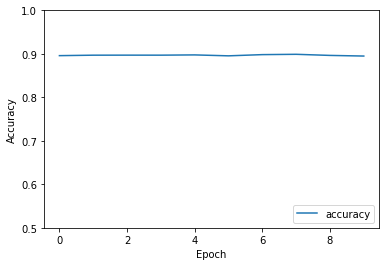

In [39]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Loss vs Epochs Plot

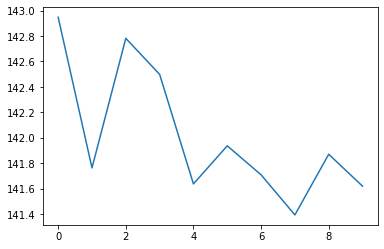

In [40]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Results


In [180]:
test_eval = model.predict(data_test)

In [181]:
print(test_eval.shape)

(2000, 128, 128, 3)


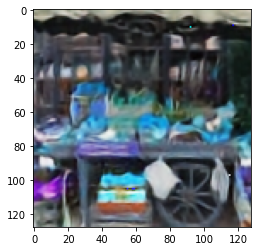

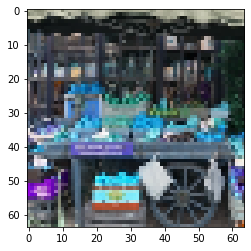

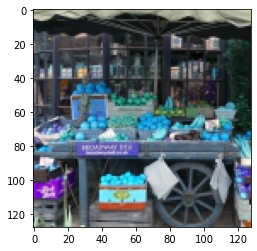

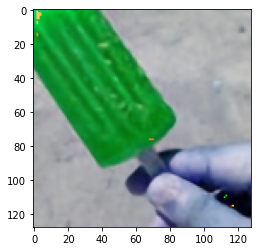

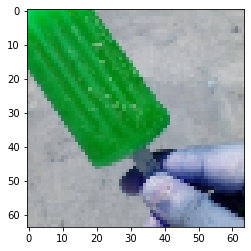

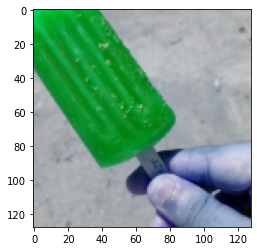

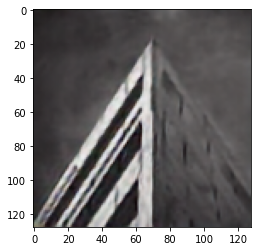

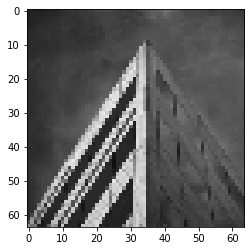

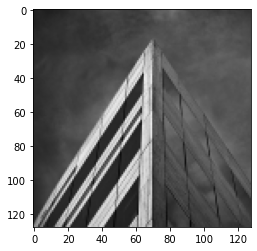

In [190]:
for i in range(1900,1903):
    
    plt.imshow(test_eval[i].astype(np.uint8))
    plt.show()
    
    plt.imshow(data_test[i].astype(np.uint8))
    plt.show()
    
    plt.imshow(labels_test[i].astype(np.uint8))
    plt.show()